In [2]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 27.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd

train = pd.read_json("/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/dataset/train.json")
dev = pd.read_json("/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/dataset/dev.json")
test = pd.read_json("/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/dataset/test.json")

In [ ]:
train = train.sample(n=20000, random_state = 42)
dev = dev.sample(n=2000, random_state = 42)
test = test.sample(n=2000, random_state = 42)

In [ ]:
import os

for fname in [
    "/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/LSTM_Bahdanau_attn.py",
    "/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/train_lstm_Bahdanau_attn.py"

]:
  open(f"{fname}", "w").close()

In [ ]:
%%writefile /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/LSTM_Bahdanau_attn.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple

class Seq2seqLSTM_Bahdanau_attn(nn.Module):
    def __init__(self,
                 d_model: int,
                 n_encoder: int,
                 n_decoder: int,
                 dropout: int,
                 vocab
    ):
        super().__init__()

        self.vocab = vocab
        self.d_model = d_model
        self.n_encoder = n_encoder
        self.n_decoder = n_decoder
        self.decoder_dim = 2 * d_model # Kích thước hidden state của Decoder (2*d_model do Encoder Bi-LSTM)

        # 1. ENCODER (Bi-LSTM, Output: 2*d_model)
        self.src_embedding = nn.Embedding(
            num_embeddings=vocab.total_src_tokens,
            embedding_dim=d_model,
            padding_idx=vocab.pad_idx
        )
        self.encoder = nn.LSTM(
            input_size=d_model,
            hidden_size=d_model,
            num_layers=n_encoder,
            batch_first=True,
            dropout=dropout,
            bidirectional=True # Encoder là Bidirectional
        )

        # 2. DECODER
        # Sửa: Embedding dim giảm về d_model (sẽ ghép với context 2*d_model)
        self.tgt_embedding = nn.Embedding(
            num_embeddings=vocab.total_tgt_tokens,
            embedding_dim=d_model,
            padding_idx=vocab.pad_idx
        )

        # Sửa: Decoder Input size = d_model (embedding) + 2*d_model (context vector) = 3*d_model
        self.decoder = nn.LSTM(
            input_size=3*d_model,
            hidden_size=self.decoder_dim, # 2*d_model
            num_layers=n_decoder,
            batch_first=True,
            dropout=dropout,
            bidirectional=False
        )

        # 3. ATTENTION
        # Dùng Additive/Concat Attention (Bahdanau et al.)
        # Input: [h_t-1_last_layer (2*d_model) ; h_j (2*d_model)] -> 4*d_model
        self.attn_weights = nn.Linear(
            in_features=4*d_model,
            out_features=1, # output 1 scalar
            bias=False
        )

        # 4. CONTEXT-AWARE OUTPUT PROJECTION (S_t)
        # Tính S_t_tilde = tanh(W_c [c_t ; h_t_last_layer])
        # Input: [context_vector (2*d_model) ; h_t_last_layer (2*d_model)] -> 4*d_model
        # Output: 2*d_model
        self.context_projection = nn.Linear(
            in_features=4*d_model,
            out_features=self.decoder_dim
        )

        # 5. OUTPUT HEAD
        # Output head nhận S_t_tilde (2*d_model)
        self.output_head = nn.Linear(
            in_features=self.decoder_dim, # 2*d_model
            out_features=vocab.total_tgt_tokens
        )
        self.loss = nn.CrossEntropyLoss(ignore_index=vocab.pad_idx)

    def aligning(self, query: torch.Tensor, k_v: torch.Tensor) -> torch.Tensor:
        '''
        Tính Context Vector c_t
        query: Trạng thái ẩn lớp cuối cùng của Decoder h_t-1 (bs, 2*d_model)
        k_v: Các Annotation Vectors của Encoder h_j (bs, len, 2*d_model)
        '''
        bs, l, _ = k_v.shape
        # (1) Mở rộng query để khớp với chiều dài câu nguồn (l)
        query_expanded = query.unsqueeze(1).repeat(1, l, 1) # (bs, len, 2*d_model)

        # (2) Tính Alignment Score (Additive/Concat)
        a = self.attn_weights(
            torch.cat([query_expanded, k_v], dim=-1) # (bs, len, 4*d_model) -> (bs, len, 1)
        )

        # (3) Chuẩn hóa bằng Softmax -> Trọng số Attention (alpha_t)
        a = F.softmax(a, dim=1) # (bs, len, 1)

        # (4) Tính Context Vector (Tổng có trọng số)
        context_vector = (a * k_v).sum(dim=1) # (bs, 2*d_model)

        return context_vector

    def forward_step(
        self,
        input_ids: torch.Tensor, # (bs, 1)
        enc_outputs: torch.Tensor, # (bs, len, 2*d_model)
        dec_states: Tuple[torch.Tensor, torch.Tensor] # (h_state, c_state)
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

        h_state, c_state = dec_states

        # 1. Tính Context Vector (c_t) từ h_t-1 (lớp cuối cùng)
        last_h_state = h_state[-1] # (bs, 2*d_model)
        context_vector = self.aligning(last_h_state, enc_outputs) # (bs, 2*d_model)

        # 2. Chuẩn bị Decoder Input (Embedded input + Context)
        embedded_input = self.tgt_embedding(input_ids).squeeze(1) # (bs, d_model)
        # Ghép embedded_input và context_vector -> (bs, 3*d_model)
        decoder_input = torch.cat([embedded_input, context_vector], dim=-1).unsqueeze(1) # (bs, 1, 3*d_model)

        # 3. Chạy Decoder LSTM
        _, (new_h_state, new_c_state) = self.decoder(decoder_input, (h_state, c_state))

        # 4. Tính Context-aware Output (s_t_tilde)
        new_last_h_state = new_h_state[-1] # (bs, 2*d_model)

        # S_t_tilde = tanh(W_c [c_t ; h_t_last_layer])
        combined_output = torch.tanh(
            self.context_projection(
                torch.cat([context_vector, new_last_h_state], dim=-1) # (bs, 4*d_model)
            )
        ) # (bs, 2*d_model)

        return new_h_state.contiguous(), new_c_state.contiguous(), combined_output

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor: # <<< FIXED: Chỉ trả về Logits
        self.train()
        embedded_x = self.src_embedding(x)
        bs, _, dim = embedded_x.shape

        # 1. Encoder (Đã sửa: Gọi 1 lần để lấy tất cả output)
        enc_outputs, (enc_hn, enc_cn) = self.encoder(embedded_x)
        enc_hidden_states = enc_outputs # Annotation Vectors (h_j)

        # 2. Khởi tạo Trạng thái Decoder
        h_0 = enc_hn[-2:].transpose(0, 1).reshape(bs, -1) # (bs, 2*d_model)
        c_0 = enc_cn[-2:].transpose(0, 1).reshape(bs, -1) # (bs, 2*d_model)

        dec_h_state = h_0.unsqueeze(0).repeat(self.n_decoder, 1, 1) # (n_decoder, bs, 2*d_model)
        dec_c_state = c_0.unsqueeze(0).repeat(self.n_decoder, 1, 1) # (n_decoder, bs, 2*d_model)
        dec_states = (dec_h_state, dec_c_state)

        _, tgt_len = y.shape # y là decoder_input (tgt[:, :-1])
        logits = []

        # 3. Decoding Loop (Teacher Forcing)
        # Lặp tgt_len lần để tạo ra tgt_len logits
        for ith in range(tgt_len): # <<< FIXED: range(tgt_len)
            y_ith = y[:, ith].unsqueeze(-1) # (bs, 1) - Từ đầu vào (teacher-forced)

            dec_h_state, dec_c_state, combined_output = self.forward_step(
                y_ith,
                enc_hidden_states,
                dec_states
            )
            dec_states = (dec_h_state, dec_c_state) # Cập nhật trạng thái

            logit = self.output_head(combined_output) # (bs, total_tgt_tokens)
            logits.append(logit.unsqueeze(1))

        logits = torch.cat(logits, dim=1) # (bs, tgt_len, total_tgt_tokens)

        # 4. Trả về Logits
        return logits # <<< FIXED: Trả về logits để train.py tính loss

    def predict(self, x: torch.Tensor, max_len: int = 50):
        self.eval()
        with torch.no_grad():
            embedded_x = self.src_embedding(x)
            bs, _, _ = embedded_x.shape

            # 1. Encoder
            enc_outputs, (enc_hn, enc_cn) = self.encoder(embedded_x)
            enc_hidden_states = enc_outputs

            # 2. Khởi tạo Trạng thái Decoder (Giống trong forward)
            h_0 = enc_hn[-2:].transpose(0, 1).reshape(bs, -1)
            c_0 = enc_cn[-2:].transpose(0, 1).reshape(bs, -1)
            dec_h_state = h_0.unsqueeze(0).repeat(self.n_decoder, 1, 1)
            dec_c_state = c_0.unsqueeze(0).repeat(self.n_decoder, 1, 1)
            dec_states = (dec_h_state, dec_c_state)

            # Bắt đầu dịch với token <bos>
            y_ith = torch.zeros(bs, ).fill_(self.vocab.bos_idx).long().to(x.device).unsqueeze(-1) # (bs, 1)

            mark_eos = torch.zeros(bs, dtype=torch.bool).to(x.device)
            outputs = []

            # 3. Decoding Loop
            for _ in range(max_len):
                # forward_step trả về (new_h, new_c, combined_output)
                dec_h_state, dec_c_state, combined_output = self.forward_step(
                    y_ith,
                    enc_hidden_states,
                    dec_states
                )
                dec_states = (dec_h_state, dec_c_state) # Cập nhật trạng thái

                # Dự đoán token tiếp theo
                logit = self.output_head(combined_output)
                y_ith = logit.argmax(dim=-1).long().unsqueeze(-1) # (bs, 1)

                # Đánh dấu đã kết thúc
                mark_eos = mark_eos | (y_ith.squeeze(-1) == self.vocab.eos_idx)

                # Nếu tất cả các chuỗi trong batch đều đã kết thúc
                if all(mark_eos.tolist()):
                    break

                # Chỉ thêm các token chưa phải là <eos> vào outputs
                outputs.append(y_ith.squeeze(-1))

            if outputs:
                outputs = torch.stack(outputs, dim=1) # (bs, length)
            else:
                # Trả về tensor rỗng nếu không có gì được dịch (ví dụ, độ dài max_len quá ngắn)
                outputs = torch.empty((bs, 0), dtype=torch.long, device=x.device)

            return outputs

Overwriting /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/LSTM_Bahdanau_attn.py


In [4]:
%%writefile /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/train_lstm_Bahdanau_attn.py
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Subset # Thêm import cần thiết
import numpy as np
import os
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
from phoMT import collate_fn, phoMTDataset
from vocab import Vocab
from LSTM_Bahdanau_attn import Seq2seqLSTM_Bahdanau_attn
# Import Metrics
try:
    from torchmetrics.text.rouge import ROUGEScore
except ImportError:
    print("Vui lòng cài đặt torchmetrics: pip install torchmetrics")
    exit()

# --- Config ---
device = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_DIR = "/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/2_LSTM_Bahdanau_attn/"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# --- Logging Setup ---
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(os.path.join(CHECKPOINT_DIR, "training.log"), mode='a'),
        logging.StreamHandler()
    ],
    force=True
)

def indices_to_text(indices, vocab, is_target=True):
    tokens = []
    # Chọn từ điển phù hợp
    i2s = vocab.tgt_i2s if is_target else vocab.src_i2s

    for idx in indices:
        if isinstance(idx, torch.Tensor):
            idx = idx.item()

        # Dừng nếu gặp <eos> (chỉ có trong Target/Translation)
        if is_target and idx == vocab.eos_idx:
            break

        if idx != vocab.pad_idx:
            # Bỏ qua <bos> chỉ cho Target/Translation
            if is_target and idx == vocab.bos_idx:
                continue

            # Dùng .get để an toàn, nếu không tìm thấy thì trả về <unk>
            token = i2s.get(idx, vocab.unk_token)
            tokens.append(token)

        # Dừng nếu gặp <eos> (chỉ có trong Source)
        if not is_target and idx == vocab.eos_idx:
             break

    return " ".join(tokens)

def train(model: nn.Module, dataloader: DataLoader, epoch: int, loss_fn, optimizer):
    model.train()
    running_loss = []

    with tqdm(dataloader, desc=f"Epoch {epoch} - Training") as pbar:
        for item in pbar:
            src = item['src'].to(device)
            tgt = item['tgt'].to(device)

            optimizer.zero_grad()

            # Teacher forcing
            decoder_input = tgt[:, :-1]
            targets = tgt[:, 1:]

            logits = model(src, decoder_input)

            # Flatten để tính loss
            # logits: (bs*len, vocab_size), targets: (bs*len)
            loss = loss_fn(logits.reshape(-1, logits.shape[-1]), targets.reshape(-1))

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss.append(loss.item())
            pbar.set_postfix({"loss": np.mean(running_loss)})

    avg_loss = np.mean(running_loss)
    logging.info(f"Epoch {epoch} - Training Loss: {avg_loss:.4f}")
    return avg_loss

def evaluate(model: nn.Module, dataloader: DataLoader, epoch: int, loss_fn, vocab):
    model.eval()
    running_loss = []
    rouge_metric = ROUGEScore().to(device)

    all_preds_text = []
    all_targets_text = []

    # Flag để chỉ in ra một ví dụ duy nhất mỗi epoch
    example_printed = False

    with torch.no_grad():
        for item in tqdm(dataloader, desc=f"Epoch {epoch} - Evaluating"):
            src = item['src'].to(device)
            tgt = item['tgt'].to(device)

            # 1. Validation Loss
            decoder_input = tgt[:, :-1]
            targets = tgt[:, 1:]
            logits = model(src, decoder_input)
            loss = loss_fn(logits.reshape(-1, logits.shape[-1]), targets.reshape(-1))
            running_loss.append(loss.item())

            # 2. ROUGE-L Prediction
            # Sinh văn bản (Inference)
            generated_tokens = model.predict(src, max_len=tgt.shape[1] + 10)

            # Xử lý trường hợp generated_tokens rỗng
            if generated_tokens.shape[1] == 0:
                generated_tokens = torch.zeros(tgt.shape[0], 1, dtype=torch.long, device=device)

            for i in range(len(tgt)):
                # Decode output của model (Translation)
                pred_seq = generated_tokens[i].tolist()
                pred_text = indices_to_text(pred_seq, vocab, is_target=True)

                # Decode nhãn thật (Reference)
                tgt_seq = tgt[i].tolist()
                tgt_text = indices_to_text(tgt_seq, vocab, is_target=True)

                # LOGIC IN VÍ DỤ
                if not example_printed:
                    # Decode Source (English)
                    src_seq = src[i].tolist()
                    src_text = indices_to_text(src_seq, vocab, is_target=False)

                    logging.info(f"\n--- Example Translation (Epoch {epoch}) ---")
                    logging.info(f"Source:      {src_text}")
                    logging.info(f"Reference:   {tgt_text}")
                    logging.info(f"Translation: {pred_text}")
                    logging.info("-" * 45)
                    example_printed = True # Đảm bảo chỉ in một lần

                all_preds_text.append(pred_text)
                all_targets_text.append(tgt_text)

    # Tính ROUGE trên tập Validation
    if len(all_preds_text) > 0:
        rouge_scores = rouge_metric(all_preds_text, all_targets_text)
        rouge_l = rouge_scores['rougeL_fmeasure'].item()
    else:
        rouge_l = 0.0

    avg_loss = np.mean(running_loss)
    logging.info(f"Epoch {epoch} - Val Loss: {avg_loss:.4f} | ROUGE-L: {rouge_l:.4f}")

    return avg_loss, rouge_l

def visualize_metrics(train_losses, val_losses, rouge_scores):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', marker='s')
    plt.title("Loss History")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, rouge_scores, label='Val ROUGE-L', marker='^', color='green')
    plt.title("ROUGE-L Score History")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def main():
    logging.info("="*50)
    logging.info(f"Starting training on Device: {device}")
    vocab = Vocab(
        path="/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/dataset",
        src_language="english",
        tgt_language="vietnamese"
    )

    # Lấy toàn bộ dataset
    train_dataset_full = phoMTDataset("/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/dataset/train.json", vocab)
    dev_dataset_full = phoMTDataset("/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/dataset/dev.json", vocab)
    test_dataset_full = phoMTDataset("/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/dataset/test.json", vocab)

    train_size = 20000
    dev_test_size = 2000

    # Lấy ngẫu nhiên 20k train
    train_indices = torch.randperm(len(train_dataset_full))[:train_size].tolist()
    train_dataset = Subset(train_dataset_full, train_indices)

    # Lấy ngẫu nhiên 2k dev
    dev_indices = torch.randperm(len(dev_dataset_full))[:dev_test_size].tolist()
    dev_dataset = Subset(dev_dataset_full, dev_indices)

    # Lấy ngẫu nhiên 2k test
    test_indices = torch.randperm(len(test_dataset_full))[:dev_test_size].tolist()
    test_dataset = Subset(test_dataset_full, test_indices)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    # Khởi tạo model (sử dụng Bahdanau Attention đã sửa ở bước trước)
    model =  Seq2seqLSTM_Bahdanau_attn(
        d_model=256,
        n_encoder=3,
        n_decoder=3,
        dropout=0.3,
        vocab=vocab
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss(ignore_index=vocab.pad_idx)

    checkpoint_path = os.path.join(CHECKPOINT_DIR, "best_lstm_mt.pt")
    best_rouge = 0.0
    start_epoch = 0

    if os.path.exists(checkpoint_path):
        ckpt = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        start_epoch = ckpt['epoch']
        best_rouge = ckpt.get('best_rouge', 0.0)
        logging.info(f"Resumed from epoch {start_epoch}, Best ROUGE: {best_rouge:.4f}")

    train_losses, val_losses, val_rouges = [], [], []
    patience = 0

    for epoch in range(start_epoch + 1, 20):
        logging.info(f"\n--- Epoch {epoch} ---")

        t_loss = train(model, train_loader, epoch, loss_fn, optimizer)
        # Trong evaluate sẽ in ra 1 ví dụ
        v_loss, v_rouge = evaluate(model, dev_loader, epoch, loss_fn, vocab)

        train_losses.append(t_loss)
        val_losses.append(v_loss)
        val_rouges.append(v_rouge)

        if v_rouge > best_rouge:
            best_rouge = v_rouge
            patience = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_rouge': best_rouge
            }, checkpoint_path)
            logging.info(f"✓ Saved Best Model (ROUGE-L: {best_rouge:.4f})")
        else:
            patience += 1
            logging.info(f"No improvement. Patience: {patience}/10")
            if patience >= 10:
                logging.info("Early stopping!")
                break

    logging.info("\nEvaluating on Test Set with Best Model...")
    ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])

    test_loss, test_rouge = evaluate(model, test_loader, 0, loss_fn, vocab)
    logging.info(f"Test Loss: {test_loss:.4f} | Test ROUGE-L: {test_rouge:.4f}")

    visualize_metrics(train_losses, val_losses, val_rouges)

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        logging.error(f"Error: {str(e)}", exc_info=True)

Overwriting /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/train_lstm_Bahdanau_attn.py


2025-12-16 13:53:35,853 - INFO - ==================================================
2025-12-16 13:53:35,855 - INFO - Starting training on Device: cuda


Building vocabulary...
Vocab created. Src tokens: 19835, Tgt tokens: 7839


2025-12-16 13:53:37,413 - INFO - 
--- Epoch 1 ---
Epoch 1 - Training: 100%|██████████| 625/625 [02:33<00:00,  4.07it/s, loss=6.31]
2025-12-16 13:56:10,881 - INFO - Epoch 1 - Training Loss: 6.3066
Epoch 1 - Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]2025-12-16 13:56:10,973 - INFO - 
--- Example Translation (Epoch 1) ---
2025-12-16 13:56:10,974 - INFO - Source:      <bos> with all the inequality towards women in the world it s hard to shed a tear for the kasi men but what do you think <eos>
2025-12-16 13:56:10,974 - INFO - Reference:   với tất cả sự bất bình đẳng đối với phụ nữ trên thế giới thật khó để đổ một giọt nước mắt cho những người đàn ông kasi nhưng bạn nghĩ sao
2025-12-16 13:56:10,977 - INFO - Translation: và chúng ta có thể ra rằng chúng ta có thể ra rằng chúng ta có thể ra rằng chúng ta có thể ra rằng chúng ta có thể ra rằng chúng ta có thể ra rằng chúng ta có thể ra
2025-12-16 13:56:10,978 - INFO - ---------------------------------------------
Epoch 1 - Evaluating: 10

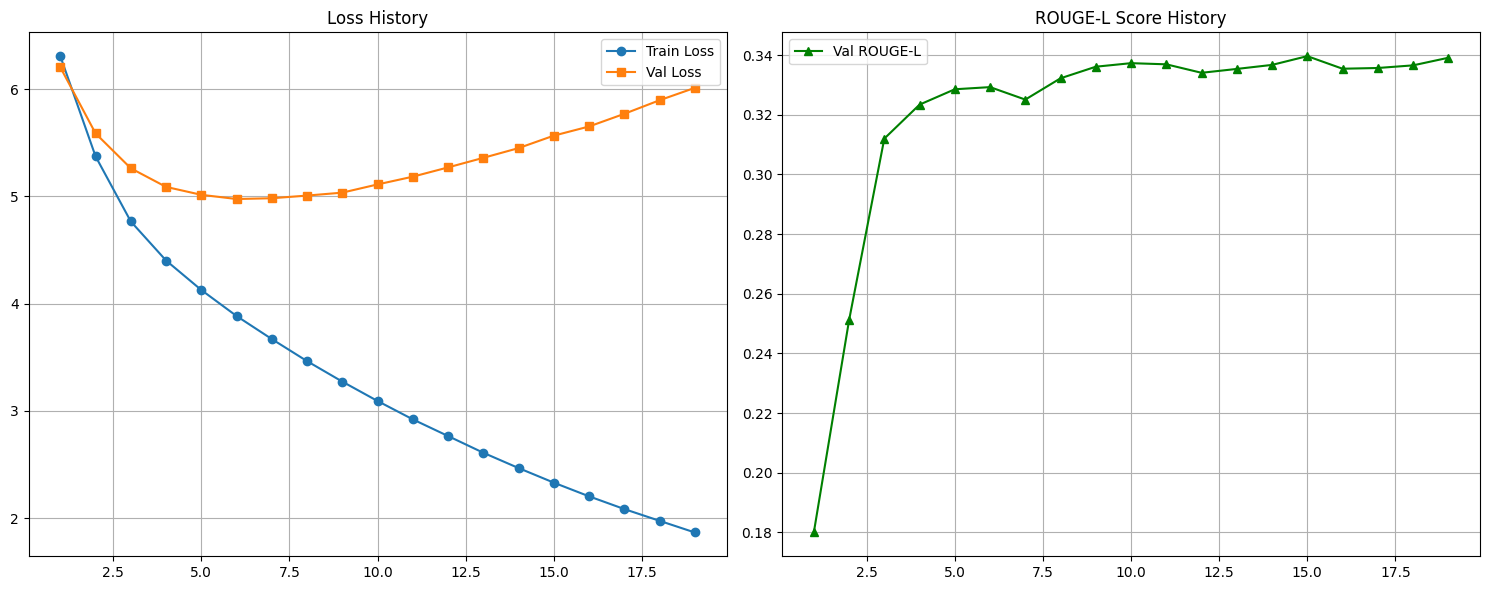

<Figure size 640x480 with 0 Axes>

In [6]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4')
%run /content/drive/MyDrive/Kì_1_Năm_3/DS200/DL-LAB4/train_lstm_Bahdanau_attn.py